In [54]:
%pip install openai hdbscan umap-learn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1.2 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## Preprocessing

In [1]:
draw_plot = False

In [10]:
import os
os.listdir(directory)

['2SUvWfNJSsM.alignments.json',
 '3d6DsjIBzJ4.alignments.json',
 '3mFLsqJmb2k.alignments.json',
 '3s7h2MHQtxc.alignments.json',
 '8GPy_UMV-08.alignments.json',
 'AHOplFzKI38.alignments.json',
 'AmgkSdhK4K8.alignments.json',
 'anDIASMNmCQ.alignments.json',
 'AznJ6ihekLg.alignments.json',
 'bcPTiiiYDs8.alignments.json',
 'bdMfjfT0lKk.alignments.json',
 'BLkz5LGWihw.alignments.json',
 'FnJqaIESC2s.alignments.json',
 'F_0yfvm0UoU.alignments.json',
 'gxAaO2rsdIs.alignments.json',
 'Iq1a_KJTWJ8.alignments.json',
 'IxNb1WG_Ido.alignments.json',
 'Kas0tIxDvrg.alignments.json',
 'kfF40MiS7zA.alignments.json',
 'liL66CApESk.alignments.json',
 'ly4S0oi3Yz8.alignments.json',
 'm2MIpDrF7Es.alignments.json',
 'mvmuCPvRoWQ.alignments.json',
 'NaL_Cb42WyY.alignments.json',
 'nCBDCR5102A.alignments.json',
 'Pjwq8rtFYl0.alignments.json',
 'qb40J4N1fa4.alignments.json',
 'Qe6o9j4IjTo.alignments.json',
 'QJYmyhnaaek.alignments.json',
 'R7p-nPg8t_g.alignments.json',
 'rB83DpBJQsE.alignments.json',
 'rfG8ce

In [18]:
import os
import json

directory = 'alignments'
segments = []

for f in os.listdir(directory):
    if not f.endswith('.json'):
        continue

    with open(os.path.join(directory, f), 'r') as file:
        data = json.load(file)

    if 'segments' not in data:
        continue

    segments.append(data['segments'])


In [19]:
import pandas as pd

def prepare(segments):
    # Remove single word segments

    segments = [
        s for s in segments
        if len(s['words'] or []) > 1
    ]

    df = pd.DataFrame(segments)
    df['text'] = df['text'].apply(lambda x: x.replace('\n', ' ').strip())
    df['duration'] = df['end'] - df['start']
    df['dt'] = df['start'] - df['end'].shift(1)
    df['dt'].fillna(0, inplace=True)
    df.drop(columns=['words'], inplace=True)

    return df

transcripts = [prepare(a) for a in segments]
transcripts[0].head()


,start,end,text,duration,dt
0,4.383,11.125,"Today, I want to share with you a neat way to ...",6.742,0.0
1,11.125,16.707,"And surprisingly, this stuff relates to findin...",5.582,0.0
2,16.707,19.268,I learned about this from a former CS lecturer...,2.561,0.0
3,19.268,24.410,"His name's Keith Schwartz, and I've got to say...",5.142,0.0
4,24.410,30.772,I actually recorded a bit of the conversation ...,6.362,0.0


In [20]:
import pandas as pd
from nltk.tokenize import sent_tokenize
import nltk
nltk.download('punkt')

def is_sentence_start(row_text, sentences):
    for sentence in sentences:
        if sentence.startswith(row_text):
            return True
    return False

def with_sentences(df: pd.DataFrame, segments):

    for item in segments:
        item['text'] = item['text'].replace('\n', ' ').strip()

    text_to_split = ' '.join([line['text'] for line in segments])
    sentences = sent_tokenize(text_to_split)
    # Create a boolean list for sentence starts
    sentence_start_flags = [is_sentence_start(row["text"], sentences) for index, row in df.iterrows()]

    # Add the boolean list as a new column in the dataframe
    df['sentence_start'] = sentence_start_flags
    return df

transcripts = [with_sentences(df, segments) for df, segments in zip(transcripts, segments)]


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\zhakh\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [21]:
WINDOW_DURATAION = 30

def window_func(df, index):
    indices = []
    total_duration = 0
    current_index = index

    while (total_duration <= WINDOW_DURATAION) and (current_index < len(df)):
        total_duration += df.loc[current_index, 'duration']

        if total_duration <= WINDOW_DURATAION:
            indices.append(current_index)
        current_index += 1

    return indices

def with_sliding_windows(df: pd.DataFrame):
    df['rolling_text'] = ''

    for index, row in df.iterrows():
        # Get window indices for the current row using our window_func
        idx = window_func(df, index)

        # # Combine the text within the window to create rolling_text
        df.at[index, 'rolling_text'] = ' '.join(df.loc[idx, 'text'])

    return df

transcripts = [with_sliding_windows(df) for df in transcripts]

## Vectorization

In [15]:
%reload_ext dotenv
%dotenv

from concurrent.futures import ThreadPoolExecutor
import os
import openai

def add_embedding(input):
    resp = openai.Embedding.create(
        model="text-embedding-ada-002",
        input=input,
    )
    return resp['data'][0]['embedding']

def process_embeddings_in_batches(rolling_texts: list, batch_size=10):
    all_embeddings = []
    with ThreadPoolExecutor() as executor:
        for i in range(0, len(rolling_texts), batch_size):
            batch_text = rolling_texts[i:i+batch_size]
            batch_embeddings = list(executor.map(add_embedding, batch_text))
            all_embeddings.extend(batch_embeddings)
    return all_embeddings

def with_embeddings(df: pd.DataFrame):
    df['embedding'] = process_embeddings_in_batches(list(df['rolling_text']))
    return df

transcripts = [with_embeddings(df) for df in transcripts]


In [21]:
import os
import json

if not os.path.exists('transcripts/'):
    os.makedirs('transcripts/')

for filename, df in zip(os.listdir('alignments/'), transcripts):
    if len(df) < 36:
        continue
    
    with open(f'transcripts/{filename}', 'w') as f:
        json.dump(df.to_dict('records'), f, indent=2)


In [2]:
import os
import json

# Delete files from transcripts folder that are shorter than 36 elements
for filename in os.listdir('transcripts/'):
    with open(f'transcripts/{filename}', 'r') as f:
        file_len = len(json.load(f))
    if file_len < 36:
        os.remove(f'transcripts/{filename}')

## Clustering

In [2]:
import os
import pandas as pd

files = os.listdir('transcripts')
transcripts = []

for filename in files:
    with open(f'transcripts/{filename}') as f:
        transcripts.append(pd.read_json(f))


In [5]:
def plot_start(df: pd.DataFrame):
    df['start'].plot(figsize=(16, 8))

In [6]:
def plot_dt(df: pd.DataFrame):
    df['dt'].plot(figsize=(16, 8))

<AxesSubplot: >

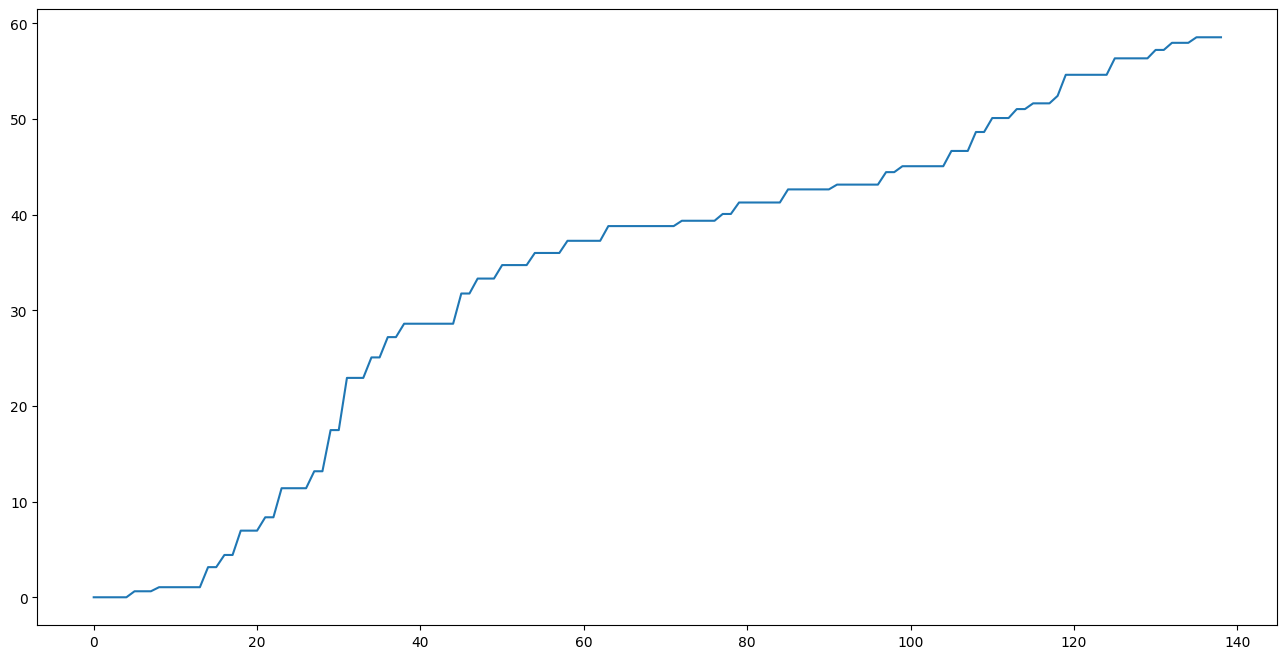

In [241]:
def plot_dt_cumsum(df: pd.DataFrame):
    df['dt'].cumsum().plot(figsize=(16, 8))

The formula below calculates the adjacency of each transcript segment. 
It uses the start time of the segment, the cumulative sum of the duration (dt), and the maximum duration.
The formula is implemented in the function `with_adjacency`.

\begin{equation}
adj = \left(1 + \frac{start}{\max(start)}\right)^{1 + \frac{\sum(dt)}{\max(\sum(dt))}} \times \max(dt)
\end{equation}

where `start` - start time of the segment; `dt` - duration between end of the previous segment and the beginning of the current; `max(start)` - maximum start time across all segments; `sum(dt)` - cumulative sum of the duration across all segments up to the `ith` one; `max(dt)` - maximum duration across all segments


In [3]:
def with_adjacency(df: pd.DataFrame, draw_plot: bool = False) -> pd.DataFrame:
    df['adj'] = df['dt'].cumsum()
    df['adj'] = df['adj'] / df['adj'].max()
    df['adj'] = (1 + df['start'] / df['start'].max()) ** (1 + df['adj']) * df['dt'].max()
    
    if draw_plot:
        df['adj'].plot(figsize=(16, 8))
    
    return df

transcripts = [with_adjacency(df, draw_plot) for df in transcripts]
transcripts[0].head()

,start,end,text,duration,dt,sentence_start,rolling_text,embedding,adj
0,4.383,11.125,"Today, I want to share with you a neat way to ...",6.742,0.0,True,"Today, I want to share with you a neat way to ...","[0.015926321968436002, 0.002179247094318, -0.0...",5.485118
1,11.125,16.707,"And surprisingly, this stuff relates to findin...",5.582,0.0,True,"And surprisingly, this stuff relates to findin...","[0.015088825486600002, 0.009931190870702001, 0...",5.529908
2,16.707,19.268,I learned about this from a former CS lecturer...,2.561,0.0,True,I learned about this from a former CS lecturer...,"[0.007312928326427001, 0.004104463383555, 0.02...",5.566991
3,19.268,24.410,"His name's Keith Schwartz, and I've got to say...",5.142,0.0,True,"His name's Keith Schwartz, and I've got to say...","[-0.008164005354046001, -0.010517122223973, 0....",5.584005
4,24.410,30.772,I actually recorded a bit of the conversation ...,6.362,0.0,True,I actually recorded a bit of the conversation ...,"[-0.010203088633716, -0.014070494100451001, 0....",5.618165


In [4]:
from sklearn.neighbors import NearestNeighbors
from umap.umap_ import UMAP
import matplotlib.pyplot as plt
import numpy as np

import pandas as pd
import numpy as np
from umap.umap_ import UMAP
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

def get_epsilons(df: pd.DataFrame, n_components: int = 32, draw_plot = False) -> float:
    X = np.vstack(df['embedding'].values).copy()
    X = UMAP(random_state=42, n_components=32).fit_transform(X)
    X = np.multiply(X, df['adj'].to_numpy().reshape(-1, 1))

    neigh = NearestNeighbors(n_neighbors=2)
    nbrs = neigh.fit(X)
    distances, indices = nbrs.kneighbors(X)

    distances = np.sort(distances, axis=0)
    distances = distances[:,1]

    if draw_plot:
        plt.figure(figsize=(15, 10))
        plt.plot(distances)

    diff = np.diff(distances)
    index = np.where(diff == diff.max())
    eps = distances[index][0]

    return eps

epsilons = [get_epsilons(transcript, 32, draw_plot) for transcript in transcripts]
epsilons[0]

c:\Users\zhakh\AppData\Local\Programs\Python\Python310\lib\site-packages\umap\distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
c:\Users\zhakh\AppData\Local\Programs\Python\Python310\lib\site-packages\umap\distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
c:\Users\zhakh\AppData\Local\Programs\Python\Python3

10.347763684481436

In [7]:
import pandas as pd
import numpy as np
from umap.umap_ import UMAP
from hdbscan import HDBSCAN
import matplotlib.pyplot as plt

def with_clusters(df, eps, draw_plot=False):
    X = np.vstack(df['embedding'].values).copy()
    X = UMAP(random_state=42, n_components=30).fit_transform(X)
    X = np.multiply(X, df['adj'].to_numpy().reshape(-1, 1))

    cluster = HDBSCAN(cluster_selection_method='leaf', cluster_selection_epsilon=float(eps))
    labels = cluster.fit_predict(X)
    df['label'] = labels

    if draw_plot:
        X_plot = UMAP(random_state=42, n_components=2).fit_transform(X)
        plt.figure(figsize=(15, 10))

        unique_labels = set(labels)
        colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

        for k, col in zip(unique_labels, colors):
            if k == -1:
                # Black used for noise (outliers)
                col = [0, 0, 0, 1]

            class_member_mask = (labels == k)

            # Plot the points that belong to the cluster
            xy = X[class_member_mask]
            plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col), markeredgecolor='k', markersize=6)

        # Plot the outliers (noise)
        noise_mask = (labels == -1)
        xy = X_plot[noise_mask]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor='k', markeredgecolor='k', markersize=6)

        plt.title('Clustering')
        plt.xlabel('X-axis')
        plt.ylabel('Y-axis')

        plt.show()

    return df

transcripts = [with_clusters(transcript, eps, draw_plot) for transcript, eps in zip(transcripts, epsilons)]
transcripts[0].head()

,start,end,text,duration,dt,sentence_start,rolling_text,embedding,adj,label
0,4.383,11.125,"Today, I want to share with you a neat way to ...",6.742,0.0,True,"Today, I want to share with you a neat way to ...","[0.015926321968436002, 0.002179247094318, -0.0...",5.485118,1
1,11.125,16.707,"And surprisingly, this stuff relates to findin...",5.582,0.0,True,"And surprisingly, this stuff relates to findin...","[0.015088825486600002, 0.009931190870702001, 0...",5.529908,1
2,16.707,19.268,I learned about this from a former CS lecturer...,2.561,0.0,True,I learned about this from a former CS lecturer...,"[0.007312928326427001, 0.004104463383555, 0.02...",5.566991,1
3,19.268,24.410,"His name's Keith Schwartz, and I've got to say...",5.142,0.0,True,"His name's Keith Schwartz, and I've got to say...","[-0.008164005354046001, -0.010517122223973, 0....",5.584005,1
4,24.410,30.772,I actually recorded a bit of the conversation ...,6.362,0.0,True,I actually recorded a bit of the conversation ...,"[-0.010203088633716, -0.014070494100451001, 0....",5.618165,1


# Post-processing

In [8]:
# Present labeled transcript lines
import matplotlib.pyplot as plt
import pandas as pd

def plot_sequence(df: pd.DataFrame, show_outliers=False):
  unique_labels = df['label'].unique()

  colors = { l: plt.cm.Spectral(l / len(unique_labels)) for i, l in enumerate(unique_labels)}

  plt.figure(figsize=(30, 6))

  # Plot the sequence of dots
  for i, l in enumerate(df['label']):
      if l == -1 and not show_outliers:
          continue
      plt.plot(i, 0, 'o', markerfacecolor='k' if l == -1 else tuple(colors[l]), markeredgecolor='k', markersize=8)

  plt.title('Sequence of Labels')
  plt.xlabel('Index')
  plt.yticks([])  # Remove y-axis ticks as they are not needed in this visualization
  plt.show()

# plot_sequence(True)

In [10]:
def cleanup_outliers(df: pd.DataFrame, draw_plot=False):
    # Cleanup outliers
    df.loc[(df['sentence_start'] == False), 'label'] = -1

    # Present only the transcript items that start the sentence
    if draw_plot:
        plot_sequence(df)

    return df

transcripts = [cleanup_outliers(transcript, draw_plot) for transcript in transcripts]
transcripts[0].head()

,start,end,text,duration,dt,sentence_start,rolling_text,embedding,adj,label
0,4.383,11.125,"Today, I want to share with you a neat way to ...",6.742,0.0,True,"Today, I want to share with you a neat way to ...","[0.015926321968436002, 0.002179247094318, -0.0...",5.485118,1
1,11.125,16.707,"And surprisingly, this stuff relates to findin...",5.582,0.0,True,"And surprisingly, this stuff relates to findin...","[0.015088825486600002, 0.009931190870702001, 0...",5.529908,1
2,16.707,19.268,I learned about this from a former CS lecturer...,2.561,0.0,True,I learned about this from a former CS lecturer...,"[0.007312928326427001, 0.004104463383555, 0.02...",5.566991,1
3,19.268,24.410,"His name's Keith Schwartz, and I've got to say...",5.142,0.0,True,"His name's Keith Schwartz, and I've got to say...","[-0.008164005354046001, -0.010517122223973, 0....",5.584005,1
4,24.410,30.772,I actually recorded a bit of the conversation ...,6.362,0.0,True,I actually recorded a bit of the conversation ...,"[-0.010203088633716, -0.014070494100451001, 0....",5.618165,1


In [11]:
import pandas as pd
# Fill the gaps

def fill_gaps(df: pd.DataFrame, draw_plot: bool = False):
    df['label'] = df['label'].replace(-1, method='ffill')
    df['label'] = df['label'].replace(-1, method='bfill')

    if draw_plot:
        plot_sequence(df)
        
    return df

transcripts = [fill_gaps(transcript, draw_plot) for transcript in transcripts]
transcripts[0].head()

,start,end,text,duration,dt,sentence_start,rolling_text,embedding,adj,label
0,4.383,11.125,"Today, I want to share with you a neat way to ...",6.742,0.0,True,"Today, I want to share with you a neat way to ...","[0.015926321968436002, 0.002179247094318, -0.0...",5.485118,1
1,11.125,16.707,"And surprisingly, this stuff relates to findin...",5.582,0.0,True,"And surprisingly, this stuff relates to findin...","[0.015088825486600002, 0.009931190870702001, 0...",5.529908,1
2,16.707,19.268,I learned about this from a former CS lecturer...,2.561,0.0,True,I learned about this from a former CS lecturer...,"[0.007312928326427001, 0.004104463383555, 0.02...",5.566991,1
3,19.268,24.410,"His name's Keith Schwartz, and I've got to say...",5.142,0.0,True,"His name's Keith Schwartz, and I've got to say...","[-0.008164005354046001, -0.010517122223973, 0....",5.584005,1
4,24.410,30.772,I actually recorded a bit of the conversation ...,6.362,0.0,True,I actually recorded a bit of the conversation ...,"[-0.010203088633716, -0.014070494100451001, 0....",5.618165,1


In [12]:
def fix_overlaps(df: pd.DataFrame, draw_plot: bool = False):
    # Fix overlaps by dominant label
    df['label_boundaries'] = False
    df.loc[df['label'] != df['label'].shift(1), 'label_boundaries'] = True
    unique_labels = df['label'].unique()

    chapter_starts_and_ends = {}

    for label in unique_labels:
        if label < 0:
            continue

        chapter_starts_and_ends[label] = df.index[df['label'] == label].min(), df.index[df['label'] == label].max()


    for label, (start, end) in chapter_starts_and_ends.items():
        for label2, (start2, end2) in chapter_starts_and_ends.items():
            if label2 != label and (start2 < end and end2 > end):
                dominant_label = df.iloc[start2:end]['label'].mode()[0]
                df.iloc[start2:end, df.columns.get_loc('label')] = dominant_label

    if draw_plot:
        plot_sequence(df)
        
    return df

transcripts = [fix_overlaps(transcript, draw_plot) for transcript in transcripts]
transcripts[0].head()

,start,end,text,duration,dt,sentence_start,rolling_text,embedding,adj,label,label_boundaries
0,4.383,11.125,"Today, I want to share with you a neat way to ...",6.742,0.0,True,"Today, I want to share with you a neat way to ...","[0.015926321968436002, 0.002179247094318, -0.0...",5.485118,2,True
1,11.125,16.707,"And surprisingly, this stuff relates to findin...",5.582,0.0,True,"And surprisingly, this stuff relates to findin...","[0.015088825486600002, 0.009931190870702001, 0...",5.529908,2,False
2,16.707,19.268,I learned about this from a former CS lecturer...,2.561,0.0,True,I learned about this from a former CS lecturer...,"[0.007312928326427001, 0.004104463383555, 0.02...",5.566991,2,False
3,19.268,24.410,"His name's Keith Schwartz, and I've got to say...",5.142,0.0,True,"His name's Keith Schwartz, and I've got to say...","[-0.008164005354046001, -0.010517122223973, 0....",5.584005,2,False
4,24.410,30.772,I actually recorded a bit of the conversation ...,6.362,0.0,True,I actually recorded a bit of the conversation ...,"[-0.010203088633716, -0.014070494100451001, 0....",5.618165,2,False


# Chapter Labeling

In [17]:
%reload_ext dotenv
%dotenv

import pandas as pd
import openai

def generate_titles(df: pd.DataFrame):
    unique_labels = df['label'].unique()
    MODEL = 'gpt-4'
    TEMPERATURE = 0.5
    MAX_TOKENS = 10
    titles = []

    df['title'] = ''  # Add title column to dataframe

    for i in range(len(unique_labels)):
        if i == 0:
            chapter_number = 1
            chapters = [
                df['text'][df['label'] == unique_labels[0]],
                df['text'][df['label'] == unique_labels[1]]
            ]
            task = "You will be provided 2 chapters that start the video, "\
            f"and your task is to title chapter {chapter_number} in 3 words or less "\
            "that explain it in context of provided chapters."
        elif i == len(unique_labels) - 1:
            chapter_number = len(unique_labels) + 1
            chapters = [
                df['text'][df['label'] == unique_labels[len(unique_labels) - 2]],
                df['text'][df['label'] == unique_labels[len(unique_labels) - 1]]
            ]
            task = f"You will be provided 2 chapters that ends the video, "\
            f"and your task is to title chapter {chapter_number} in 3 words "\
            "or less that explain it in context of provided chapters."
        else:
            chapters = [
                df['text'][df['label'] == unique_labels[i - 1]],
                df['text'][df['label'] == unique_labels[i]],
                df['text'][df['label'] == unique_labels[i + 1]],
            ]
            chapter_number = i + 2
            task = f"You will be provided with 3 chapters, and your task "\
            f"is to title chapter {chapter_number} in 3 words or less "\
            "that explain it in context of provided chapters."


        chapters = ['\n'.join(text) for text in chapters]
        chapters = "\n\n".join([f"## Chapter {i + k + 1}\n{text}" for k, text in enumerate(chapters)])

        context = f"{task}\n" \
        f"{chapters}\n\n" \
        f"Chapter {chapter_number} title:"

        reply = openai.ChatCompletion.create(
            model=MODEL,
            messages=[{'role': 'system', 'content': context}],
            temperature=TEMPERATURE,
            max_tokens=MAX_TOKENS
        )

        title = reply['choices'][0]['message']['content'].strip('"')
        titles.append(title)
        df.loc[df['label'] == unique_labels[i], 'title'] = title  # Assign title to corresponding label

    return df

transcripts = [generate_titles(transcript) for transcript in transcripts]


IndexError: index 1 is out of bounds for axis 0 with size 1

In [ ]:
def generate_chapters(df):
    titles = df['title'].unique()
    starts = [df.loc[df.index[df['title'] == title][0], 'start'] for title in titles]
    return pd.DataFrame(zip(starts, titles), columns=['Start', 'Title'])

chapters_list = [generate_chapters(transcript) for transcript in transcripts]

In [ ]:
import os
import json

if not os.path.exists('chapters'):
    os.makedirs('chapters')

for filename, chapters in zip(os.listdir('transcripts/'), chapters_list):
    with open(f'chapters/{filename}', 'w') as f:
        json.dump(chapters.to_dict('records'), f, indent=2)